In [1]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Sequence, TypeAlias, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Args:
    -----
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from watermark import watermark

Model: TypeAlias = nn.Module

print(watermark(packages="polars,scikit-learn,torch,lightning", python=True))
print("Torch CUDA available?: ", torch.cuda.is_available())

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

polars      : 0.20.18
scikit-learn: 1.4.1.post1
torch       : 2.2.2
lightning   : 2.2.1

Torch CUDA available?:  False


### Create Lightning Model

In [4]:
class LitModel(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float) -> None:
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate

        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)

        self.save_hyperparameters(ignore=["model"])

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def _shared_steps(self, batch) -> torch.Tensor:
        # Fetch the data
        features, true_labels = batch

        # Forward prop
        logits: torch.Tensor = self(features)
        predicted_labels: torch.Tensor = torch.argmax(logits, dim=1)

        # Compute loss
        loss: torch.Tensor = F.cross_entropy(logits, true_labels)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        # Shared steps
        loss, true_labels, predicted_labels = self._shared_steps(batch=batch)

        # Compute accuracy
        self.train_accuracy(true_labels, predicted_labels)

        # Log loss and accuracy
        self.log("train_loss", loss)
        self.log(
            "train_accuracy",
            self.train_accuracy,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        # Shared steps
        loss, true_labels, predicted_labels = self._shared_steps(batch=batch)

        # Compute accuracy
        self.val_accuracy(true_labels, predicted_labels)

        # Log loss and accuracy
        self.log("val_loss", loss)
        self.log(
            "val_accuracy",
            self.val_accuracy,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def test_step(self, batch, batch_idx) -> torch.Tensor:
        # Shared steps
        loss, true_labels, predicted_labels = self._shared_steps(batch=batch)

        # Compute accuracy
        self.test_accuracy(true_labels, predicted_labels)

        # Log accuracy
        self.log("test_accuracy", self.test_accuracy)

        return loss

    def configure_optimizers(self) -> Any:
        optimizer: Any = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

### Create Dataset

In [5]:
from torch.utils.data import Dataset


NDArray: TypeAlias = npt.NDArray[np.float_ | np.int_]


class CustomDataset(Dataset):
    def __init__(
        self, features: torch.Tensor, labels: torch.Tensor, transform: Any | None = None
    ) -> None:
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        feature = self.features[index]
        label = self.labels[index]

        if self.transform is not None:
            x = self.transform(x)

        return feature, label

    def __len__(self) -> int:
        return self.labels.shape[0]

In [6]:
np.random.seed(2)
X: NDArray = np.random.rand(5, 3)
y: NDArray = np.random.choice(a=[0, 1], size=5)

X, y

(array([[0.4359949 , 0.02592623, 0.54966248],
        [0.43532239, 0.4203678 , 0.33033482],
        [0.20464863, 0.61927097, 0.29965467],
        [0.26682728, 0.62113383, 0.52914209],
        [0.13457995, 0.51357812, 0.18443987]]),
 array([1, 0, 0, 1, 0]))

In [7]:
my_dataset: CustomDataset = CustomDataset(features=X, labels=y)
console.print(f"getter: {my_dataset[0]}")
console.print(f"length: {len(my_dataset)}")

getter: (tensor([0.4360, 0.0259, 0.5497]), tensor(1))

length: 5

### Create Lightning Data Module

In [8]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


class LitDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "../../data/classification_data.csv",
        batch_size: int = 32,
        seed: int = 123,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seed = seed

    def prepare_data(self) -> None:
        """This optional method is used to download the data."""
        pass

    def setup(self, stage: str) -> None:
        # Create data
        X, y = make_classification(
            n_samples=20_000,
            n_classes=2,
            n_features=100,
            n_informative=10,
            n_redundant=40,
            n_repeated=25,
            n_clusters_per_class=5,
            flip_y=0.05,
            class_sep=0.5,
            random_state=123,
        )
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.seed, stratify=y
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.1, random_state=self.seed, stratify=y_train
        )
        self.train_dataset = CustomDataset(features=X_train, labels=y_train)
        self.val_dataset = CustomDataset(features=X_val, labels=y_val)
        self.test_dataset = CustomDataset(features=X_test, labels=y_test)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset=self.val_dataset, batch_size=self.batch_size, shuffle=False
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset=self.test_dataset, batch_size=self.batch_size, shuffle=False
        )

### Create Pytorch Model

In [9]:
class MLP(nn.Module):
    def __init__(self, num_features: int, num_classes: int) -> None:
        super().__init__()

        self.all_layers = nn.Sequential(
            # 1st hidden layer
            nn.Linear(num_features, 64),
            nn.ReLU(),
            # 2nd hidden layer
            nn.Linear(64, 32),
            nn.ReLU(),
            # Output layer
            nn.Linear(32, num_classes),
        )

    def forward(self, x) -> torch.Tensor:
        x = torch.flatten(input=x, start_dim=1)
        logits: torch.Tensor = self.all_layers(x)
        return logits

### Training Loop

In [10]:
# Set seed
torch.manual_seed(seed=123)

data_module: LitDataModule = LitDataModule()
# Lightning Model
pytorch_model = MLP(num_features=100, num_classes=2)
lightning_model: LitModel = LitModel(model=pytorch_model, learning_rate=0.01)

### Add Model Checkpoint

In [11]:
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks: list[Any] = [
    ModelCheckpoint(
        save_top_k=3,  # save top k models based on monitored metric
        monitor="val_accuracy",  # monitor quantity for model checkpointing
        mode="max",  # use "max" or "min". i.e save the model with the best monitored quantity
        save_last=True,  # whether to save last model
    )
]

In [12]:
from lightning.pytorch.loggers import CSVLogger


# Logger
logger = CSVLogger(save_dir="logs/", name="my-model")

# Trainer
trainer = L.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    max_epochs=10,
    deterministic=True,
    logger=logger,
)

# Fit
trainer.fit(model=lightning_model, datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | MLP                | 8.6 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


/Users/neidu/Desktop/Projects/Personal/My_Projects/Deep-Learning-With-Pytorch


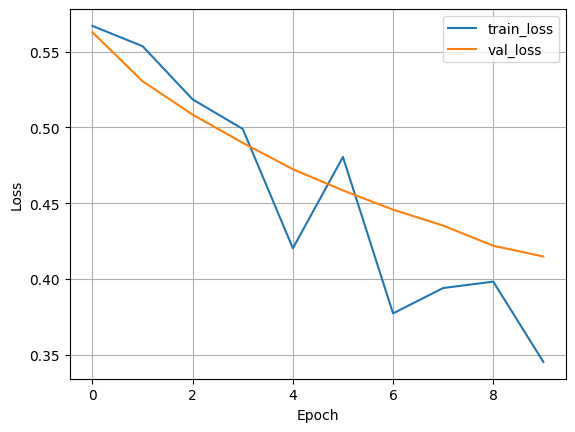

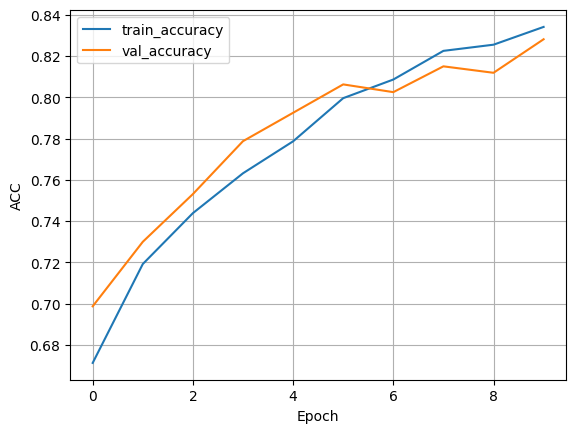

In [13]:
go_up_from_current_directory(go_up=2)
from src.helper_plotting import plot_csv_logger


plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")

### Use the Best Checkpoint

In [14]:
trainer.test(model=lightning_model, datamodule=data_module)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8199999928474426     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.8199999928474426}]

In [15]:
trainer.test(
    model=lightning_model,
    datamodule=data_module,
    ckpt_path="best",  # optional, path to best checkpoint
)

Restoring states from the checkpoint path at logs/my-model/version_10/checkpoints/epoch=9-step=4500.ckpt
Loaded model weights from the checkpoint at logs/my-model/version_10/checkpoints/epoch=9-step=4500.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8199999928474426     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.8199999928474426}]

In [16]:
trainer.test(
    model=lightning_model,
    datamodule=data_module,
    ckpt_path="last",  # load the last checkpoint
)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8199999928474426     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.8199999928474426}]

In [17]:
path: str = trainer.checkpoint_callback.best_model_path

lightning_model = LitModel.load_from_checkpoint(path, model=pytorch_model)
lightning_model.eval()

trainer.test(model=lightning_model, datamodule=data_module)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8199999928474426     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.8199999928474426}]

<br>

## Automatic Learning Rate Finder

In [18]:
# Set seed
torch.manual_seed(seed=123)

data_module: LitDataModule = LitDataModule()

# Lightning Model
pytorch_model = MLP(num_features=100, num_classes=2)
lightning_model: LitModel = LitModel(model=pytorch_model, learning_rate=0.05)

In [19]:
from lightning.pytorch.tuner import Tuner


# Logger
logger = CSVLogger(save_dir="logs/", name="my-model")

# Trainer
trainer = L.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    max_epochs=20,  # === NEW CODE ===
    deterministic=True,
    logger=logger,
)

# Create tuner
tuner: Tuner = Tuner(trainer=trainer)
# Run tuner to find learning rate automaically
learning_rate_finder = tuner.lr_find(model=lightning_model, datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.8317637711026709
Restoring states from the checkpoint path at /Users/neidu/Desktop/Projects/Personal/My_Projects/Deep-Learning-With-Pytorch/notebook/PyTorchLightning/.lr_find_dc449e96-baeb-4196-b530-0a317a037b89.ckpt
Restored all states from the checkpoint at /Users/neidu/Desktop/Projects/Personal/My_Projects/Deep-Learning-With-Pytorch/notebook/PyTorchLightning/.lr_find_dc449e96-baeb-4196-b530-0a317a037b89.ckpt


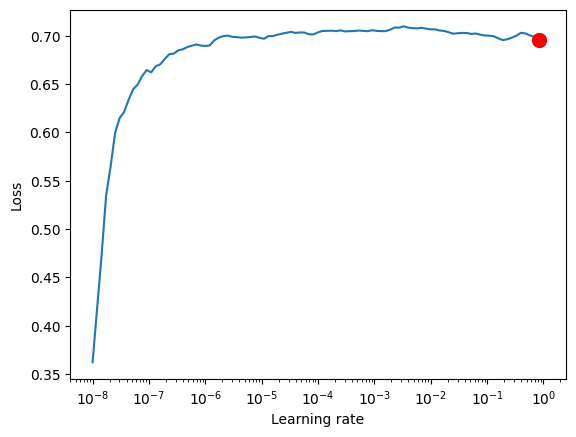

In [20]:
fig = learning_rate_finder.plot(suggest=True)

# fig.savefig("lr_suggest.pdf")

In [21]:
# Get suggestion
new_lr = learning_rate_finder.suggestion()
print(new_lr)

0.8317637711026709


In [22]:
# Update hparams of the model
lightning_model.learning_rate = new_lr

# Fit
trainer.fit(model=lightning_model, datamodule=data_module)


  | Name           | Type               | Params
------------------------------------------------------
0 | model          | MLP                | 8.6 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


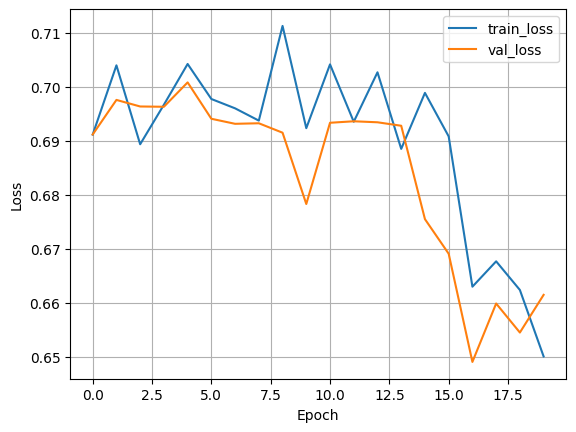

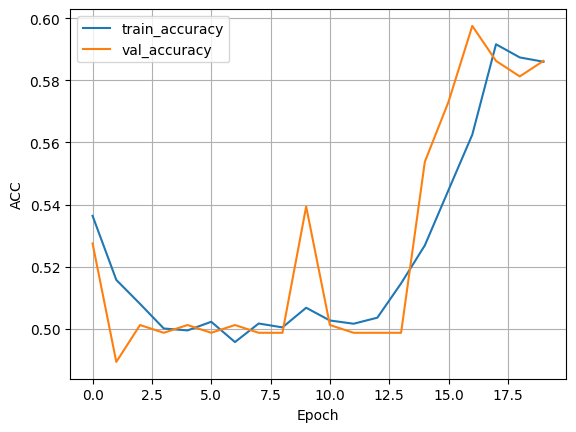

In [23]:
### Plot

metrics: pd.DataFrame = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics: list[Any] = []
agg_col: str = "epoch"

for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics: pd.DataFrame = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.savefig("suggest_loss.pdf")

df_metrics[["train_accuracy", "val_accuracy"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.savefig("suggest_acc.pdf")

plt.show()

## Using a Reduce-on-Plateau Scheduler

### Modify Lightning Model

- Add:

```py
def configure_optimizers(self) -> dict[str, Any]:
    optimizer: Any = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
    scheduler: Any = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5
    )
    return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "monitor": "train_loss",
            "intervals": "epoch",  # default
            "frequency": 1,  # default
        },
    }
```


In [24]:
class LitModel(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float) -> None:
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate

        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)

        self.save_hyperparameters(ignore=["model"])

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def _shared_steps(self, batch) -> torch.Tensor:
        # Fetch the data
        features, true_labels = batch

        # Forward prop
        logits: torch.Tensor = self(features)
        predited_labels: torch.Tensor = torch.argmax(logits, dim=1)

        # Compute loss
        loss: torch.Tensor = F.cross_entropy(logits, true_labels)

        return loss, true_labels, predited_labels

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        # Shared steps
        loss, true_labels, predited_labels = self._shared_steps(batch=batch)

        # Compute accuracy
        self.train_accuracy(true_labels, predited_labels)

        # Log loss and accuracy
        self.log("train_loss", loss)
        self.log(
            "train_accuracy",
            self.train_accuracy,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        # Shared steps
        loss, true_labels, predited_labels = self._shared_steps(batch=batch)

        # Compute accuracy
        self.val_accuracy(true_labels, predited_labels)

        # Log loss and accuracy
        self.log("val_loss", loss)
        self.log(
            "val_accuracy",
            self.val_accuracy,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def test_step(self, batch, batch_idx) -> torch.Tensor:
        # Shared steps
        loss, true_labels, predited_labels = self._shared_steps(batch=batch)

        # Compute accuracy
        self.test_accuracy(true_labels, predited_labels)

        # Log accuracy
        self.log("test_accuracy", self.test_accuracy)

        return loss

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer: Any = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler: Any = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.1, patience=5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss",
                "intervals": "epoch",  # default
                "frequency": 1,  # default
            },
        }

In [25]:
# Set seed
torch.manual_seed(seed=123)

data_module: LitDataModule = LitDataModule()

# Lightning Model
pytorch_model = MLP(num_features=100, num_classes=2)
lightning_model: LitModel = LitModel(model=pytorch_model, learning_rate=0.05)


# Logger
logger = CSVLogger(save_dir="logs/", name="my-model")

# Trainer
trainer = L.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    max_epochs=20,  # === NEW CODE ===
    deterministic=True,
    logger=logger,
)

# Fit
trainer.fit(model=lightning_model, datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | MLP                | 8.6 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


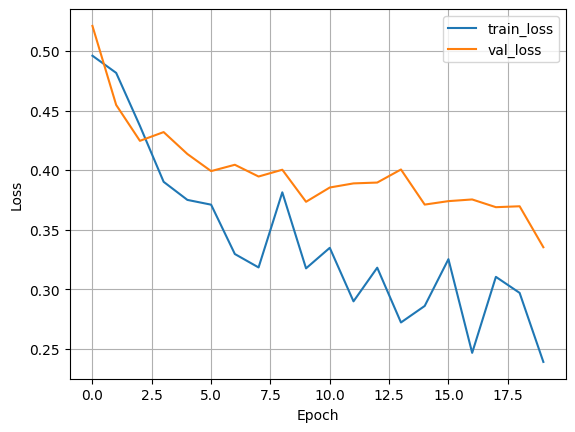

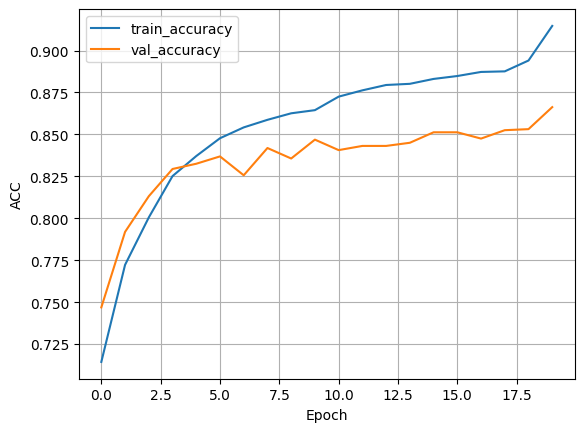

In [26]:
### Plot

metrics: pd.DataFrame = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics: list[Any] = []
agg_col: str = "epoch"

for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics: pd.DataFrame = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.savefig("suggest_loss.pdf")

df_metrics[["train_accuracy", "val_accuracy"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.savefig("suggest_acc.pdf")

plt.show()

In [27]:
trainer.test(model=lightning_model, datamodule=data_module)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8812500238418579     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.8812500238418579}]

## Using Cosine Scheduler

### Modify Lightning Model

- Add:

```py
def configure_optimizers(self) -> dict[str, Any]:
    optimizer: Any = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
    scheduler: Any = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=self.cosine_t_max, # === NEW ===
        )
    
    return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "monitor": "train_loss",
            "intervals": "step",  # step means `batch` === NEW ===
            "frequency": 1,  # default
        },
    }
```


In [28]:
class LitModel(L.LightningModule):
    def __init__(
        self, model: nn.Module, learning_rate: float, cosine_t_max: Any
    ) -> None:
        super().__init__()

        self.model = model
        self.cosine_t_max = cosine_t_max  # === New ===
        self.learning_rate = learning_rate

        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)

        self.save_hyperparameters(ignore=["model"])

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def _shared_steps(self, batch) -> torch.Tensor:
        # Fetch the data
        features, true_labels = batch

        # Forward prop
        logits: torch.Tensor = self(features)
        predited_labels: torch.Tensor = torch.argmax(logits, dim=1)

        # Compute loss
        loss: torch.Tensor = F.cross_entropy(logits, true_labels)

        return loss, true_labels, predited_labels

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        # Shared steps
        loss, true_labels, predited_labels = self._shared_steps(batch=batch)

        # Compute accuracy
        self.train_accuracy(true_labels, predited_labels)

        # Log loss and accuracy
        self.log("train_loss", loss)
        self.log(
            "train_accuracy",
            self.train_accuracy,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        # Shared steps
        loss, true_labels, predited_labels = self._shared_steps(batch=batch)

        # Compute accuracy
        self.val_accuracy(true_labels, predited_labels)

        # Log loss and accuracy
        self.log("val_loss", loss)
        self.log(
            "val_accuracy",
            self.val_accuracy,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def test_step(self, batch, batch_idx) -> torch.Tensor:
        # Shared steps
        loss, true_labels, predited_labels = self._shared_steps(batch=batch)

        # Compute accuracy
        self.test_accuracy(true_labels, predited_labels)

        # Log accuracy
        self.log("test_accuracy", self.test_accuracy)

        return loss

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer: Any = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler: Any = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.cosine_t_max,  # === NEW ===
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss",
                "intervals": "step",  # step means `batch` === NEW ===
                "frequency": 1,  # default
            },
        }

In [29]:
data_module: LitDataModule = LitDataModule()
data_module.setup("training")
num_steps: int = 10 * len(data_module.train_dataloader())

In [30]:
# Set seed
torch.manual_seed(seed=123)

epochs: int = 20
data_module: LitDataModule = LitDataModule()
data_module.setup("training")
num_steps: int = epochs * len(data_module.train_dataloader())

# Lightning Model
pytorch_model = MLP(num_features=100, num_classes=2)
lightning_model: LitModel = LitModel(
    model=pytorch_model, learning_rate=0.05, cosine_t_max=num_steps  # === NEW ===
)


# Logger
logger = CSVLogger(save_dir="logs/", name="my-model")

# Trainer
trainer = L.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    max_epochs=20,  # === NEW CODE ===
    deterministic=True,
    logger=logger,
)

# Fit
trainer.fit(model=lightning_model, datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | MLP                | 8.6 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


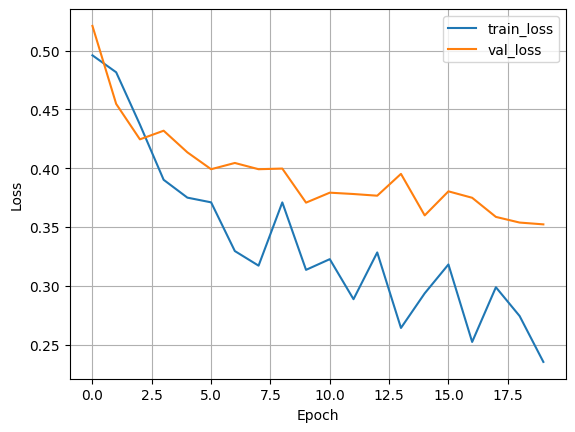

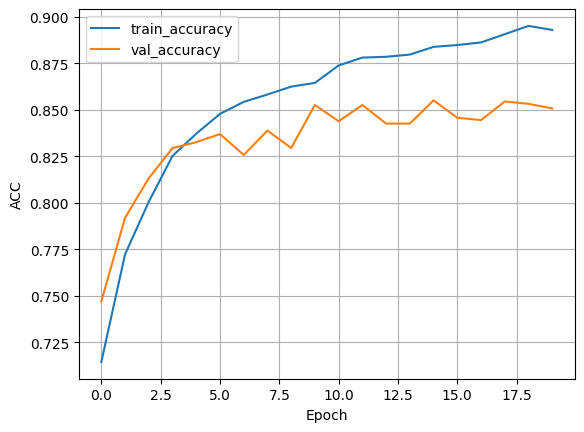

In [31]:
### Plot

metrics: pd.DataFrame = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics: list[Any] = []
agg_col: str = "epoch"

for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics: pd.DataFrame = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.savefig("suggest_loss.pdf")

df_metrics[["train_accuracy", "val_accuracy"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.savefig("suggest_acc.pdf")

plt.show()